## 1. Preprocessing 

In [27]:
#1.1 Khởi tạo dataframe
import pandas as pd
import numpy as np

path = "..\data\diabetic_data.csv"
#path = "..\data\data.csv"
df = pd.read_csv(path)


In [29]:
# 1.2 EDA (Exploratory Data Analysis)

print("Dataset Shape:", df.shape)
print("\nTóm tắt bộ dữ liệu:")
df.describe()



Dataset Shape: (101766, 50)

Tóm tắt bộ dữ liệu:


,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [30]:
# Check unique values in categorical columns
print("\nUnique Values in Categorical Columns:")
for col in ['race', 'gender', 'age', 'diabetesMed']:
    print(f"{col}: {df[col].unique()}")


Unique Values in Categorical Columns:
race: ['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
gender: ['Female' 'Male' 'Unknown/Invalid']
age: ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
diabetesMed: ['No' 'Yes']


In [31]:
# 1.3 Null cleaning
# Thay thế giá trị ? trong dataset bằng NaN
df.replace('?', np.nan, inplace=True)

# Kiểm tra giá trị bị khuyết 
#print("\nMissing Values:")
#print(df.isnull().sum())

# Loại bỏ cột chứa quá nhiều giá trị khuyết (>40%)
threshold = 0.4 * len(df)
df = df.dropna(thresh=threshold, axis=1)

# Loại bỏ hàng chứa giá trị khuyết dưới những cột quan trọng 
df = df.dropna(subset=['race', 'gender', 'age'])

# # Verify missing values after cleaning
# print("\nMissing Values After Cleaning:")
# print(df.isnull().sum())

In [32]:
# 1.4 Outliers cleaning 
numerical_cols = ['num_lab_procedures', 'num_medications', 'time_in_hospital']

def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

for col in numerical_cols:
    df = cap_outliers(df, col)

# Verify changes
print("\nSummary Statistics After Outlier Cleaning:")
print(df[numerical_cols].describe())


Summary Statistics After Outlier Cleaning:
       num_lab_procedures  num_medications  time_in_hospital
count        99493.000000     99493.000000      99493.000000
mean            43.063984        15.814962          4.366006
std             19.669902         7.394010          2.894010
min              1.000000         1.000000          1.000000
25%             31.000000        10.000000          2.000000
50%             44.000000        15.000000          4.000000
75%             57.000000        20.000000          6.000000
max             96.000000        35.000000         12.000000


In [33]:
# 1.5 Chuẩn hóa dữ liệu và giảm chiều dữ liệu
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Encode categorical variables
categorical_cols = ['race', 'gender', 'age', 'diabetesMed']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Select features for clustering
features = ['age', 'num_lab_procedures', 'num_medications', 'time_in_hospital', 'diabetesMed']
X = df[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensions to 3D for faster clustering
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_scaled)

print("\nReduced Features Shape:", X_reduced.shape)


Reduced Features Shape: (99493, 3)


## 2. CURE Algorithm 

In [37]:
# 2.1 Chạy giải thuật, huấn luyện mô hình
from pyclustering.cluster.cure import cure
X_list = X_scaled.tolist()

# Manually sample the data to speed up CURE
sample_size = 500
if len(X_list) > sample_size:
    indices = np.random.choice(len(X_list), sample_size, replace=False)
    X_sample = [X_list[i] for i in indices]
else:
    X_sample = X_list


# Parameters for CURE
k = 3  # Number of clusters
c = 10  # Number of representatives per cluster
alpha = 0.3  # Shrink factor
compression = 0.5  # Compression factor (default value)

# Run CURE on the sample
cure_instance = cure(X_sample, k, c, alpha, compression)
cure_instance.process()

# Get clusters for the sample
clusters = cure_instance.get_clusters()
sample_labels = np.zeros(len(X_sample), dtype=int)
for cluster_id, cluster in enumerate(clusters):
    for idx in cluster:
        sample_labels[idx] = cluster_id + 1

# Assign remaining points to clusters
labels = np.zeros(len(X_list), dtype=int)
if len(X_list) > sample_size:
    labels[indices] = sample_labels
    remaining_indices = np.setdiff1d(np.arange(len(X_list)), indices)
    X_remaining = np.array([X_list[i] for i in remaining_indices])

    # Get representatives for each cluster
    representatives = []
    for cluster_id in range(len(clusters)):
        if len(clusters[cluster_id]) == 0:
            continue
        cluster_points = np.array([X_sample[idx] for idx in clusters[cluster_id]])
        num_reps = min(c, len(cluster_points))
        reps = cluster_points[:num_reps]
        centroid = np.mean(cluster_points, axis=0)
        shrunk_reps = reps + alpha * (centroid - reps)
        representatives.append((cluster_id + 1, shrunk_reps))

    # Assign remaining points
    for idx, point in enumerate(X_remaining):
        min_dist = float('inf')
        assigned_cluster = 0
        for cluster_id, reps in representatives:
            dist = np.min(np.linalg.norm(reps - point, axis=1))
            if dist < min_dist:
                min_dist = dist
                assigned_cluster = cluster_id
        labels[remaining_indices[idx]] = assigned_cluster
else:
    labels = sample_labels

# Add cluster labels to the dataframe
df['Cluster'] = labels
print("\nCluster Distribution:")
print(df['Cluster'].value_counts())


Cluster Distribution:
Cluster
1    96597
3     1853
2     1043
Name: count, dtype: int64


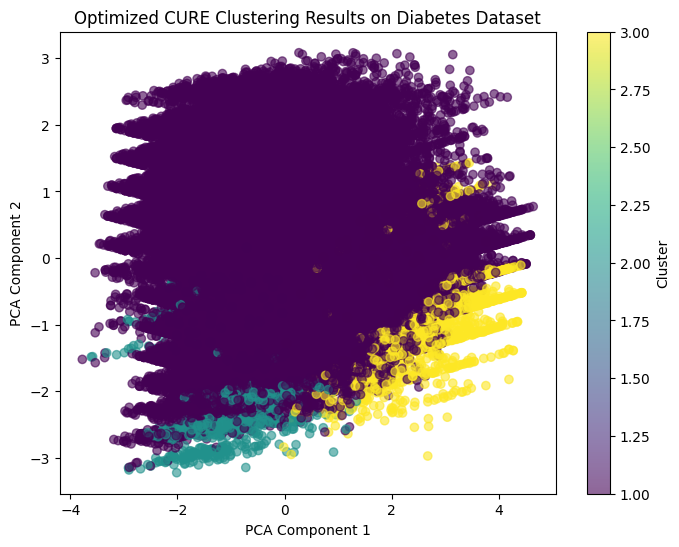

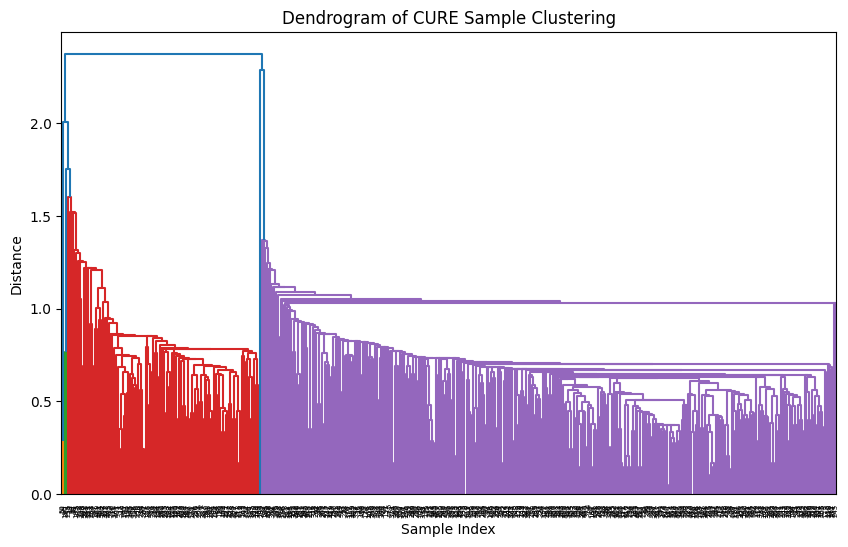

In [38]:
# 2.2 Trực quan hóa dữ liệu

import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_reduced)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.6)
plt.title('Optimized CURE Clustering Results on Diabetes Dataset')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.savefig('optimized_cure_clusters.png')
plt.show()

# Visualize Dendrogram (using scipy's hierarchical clustering on the sample)
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering on the sample for dendrogram
Z = linkage(X_sample, method='single', metric='euclidean')
plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.title('Dendrogram of CURE Sample Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.savefig('cure_dendrogram.png')
plt.show()

## 3. Evaluation

In [36]:
# 3. Evaluation
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Compute multiple evaluation metrics (excluding unassigned points)
valid_indices = df['Cluster'] != 0
X_valid = X_reduced[valid_indices]
labels_valid = df['Cluster'][valid_indices]

sil_score = silhouette_score(X_valid, labels_valid)
db_score = davies_bouldin_score(X_valid, labels_valid)
ch_score = calinski_harabasz_score(X_valid, labels_valid)

print("\nEvaluation Metrics:")
print(f"Silhouette Score: {sil_score}")
print(f"Davies-Bouldin Score: {db_score}")
print(f"Calinski-Harabasz Score: {ch_score}")

# Interpret clusters by feature means
print("\nCluster Analysis:")
cluster_summary = df.groupby('Cluster')[features].mean()
print(cluster_summary)



Evaluation Metrics:
Silhouette Score: 0.08741067863338856
Davies-Bouldin Score: 1.4409311040395834
Calinski-Harabasz Score: 9426.707247970058

Cluster Analysis:
              age  num_lab_procedures  num_medications  time_in_hospital  \
Cluster                                                                    
1        5.897913           42.484936        14.732383          4.234614   
2        7.241507           41.217280        17.126337          4.412321   
3        6.972277           56.446127        30.936099          6.435706   

         diabetesMed  
Cluster               
1           0.843762  
2           0.062932  
3           1.000000  


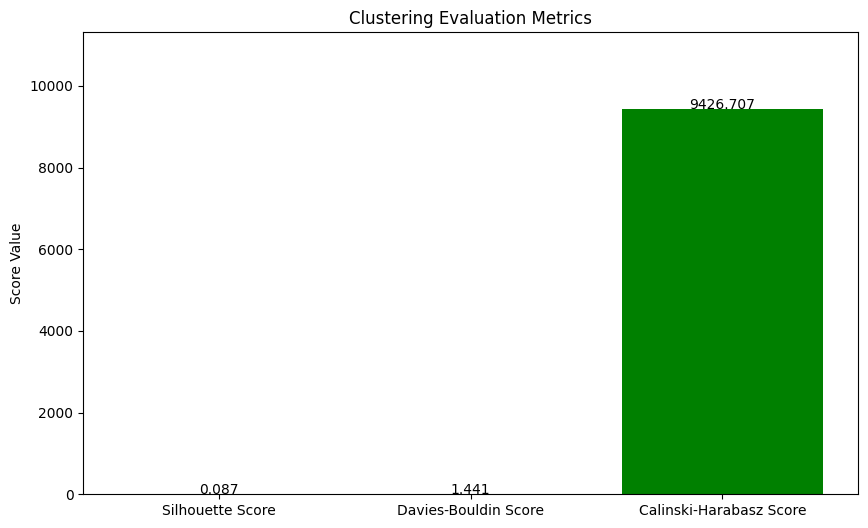


Evaluation Metrics:
Silhouette Score: 0.087
Davies-Bouldin Score: 1.441
Calinski-Harabasz Score: 9426.707

Cluster Analysis:
              age  num_lab_procedures  num_medications  time_in_hospital  \
Cluster                                                                    
1        6.179943           42.644078        15.586002          4.279408   
2        1.297220           55.229147         8.329818          2.437200   
3        4.396114           58.106314        31.963842          9.966001   

         diabetesMed  
Cluster               
1           0.764796  
2           0.894535  
3           0.907717  


In [40]:
# Visualize Evaluation Metrics
metrics = {'Silhouette Score': sil_score, 'Davies-Bouldin Score': db_score, 'Calinski-Harabasz Score': ch_score}
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

plt.figure(figsize=(10, 6))
plt.bar(metric_names, metric_values, color=['blue', 'orange', 'green'])
plt.title('Clustering Evaluation Metrics')
plt.ylabel('Score Value')
for i, v in enumerate(metric_values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
plt.ylim(0, max(metric_values) * 1.2)  # Add some padding
plt.savefig('evaluation_metrics.png')
plt.show()

print("\nEvaluation Metrics:")
print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")

# Interpret clusters by feature means
print("\nCluster Analysis:")
cluster_summary = df.groupby('Cluster')[features].mean()
print(cluster_summary)